<a href="https://colab.research.google.com/github/SusmithaaSankar/Brain-Tumor-Classification-HybridCNN/blob/main/Tumorpro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Huggingface Transformers for Swin
!pip install transformers timm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from transformers import SwinModel, SwinConfig
import timm


In [3]:
# OPTION B — dataset in Google Drive
from google.colab import drive
drive.mount('/content/drive')
from pathlib import Path
DATA_DIR = Path("/content/drive/MyDrive/BrainTumorProject")  # <- point to the folder that has Training/ and Testing/


Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive


 20200916_205036.jpg
 20200916_205051.jpg
 20200916_211021.jpg
 20200916_211553.jpg
 20200916_211611.jpg
 23BT215
 312323214051.pdf
 86195.jpg
'aadhar back.pdf'
 addaar.pdf
 Bonafied.pdf
'Colab Notebooks'
'Copy of Untitled video - Made with Clipchamp.mp4'
'doc (1).pdf'
 DOC-20240930-WA0027..pdf
 doc.pdf
 HDCOLZKUIQ.pdf
 IMG-20250107-WA0006.jpg
 Kaagaz_20250302_221338543922-7.jpg
 Kaagaz_20250303_205221015834-1.jpg
'My Camu (2).pdf'
 Screenshot_2024-09-24-18-15-47-038_com.google.android.apps.nbu.paisa.user.jpg
 shefits.docx
'SUSMITHAA (1).pdf'
 SUSMITHAA.pdf
'Untitled document (1).gdoc'
'Untitled document.gdoc'
'Untitled video - Made with Clipchamp.mp4'
 VID-20200916-WA0013.mp4
 VID_20241123_153257.mp4


In [ ]:
from google.colab import files
uploaded = files.upload()


In [1]:
from google.colab import files
uploaded = files.upload()

Saving archive (6).zip to archive (6).zip


In [3]:
import os
import zipfile

zip_path = "/content/archive (6).zip"  # the uploaded zip file
extract_path = "/content/Brain_Tumor_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Folders inside dataset:", os.listdir(extract_path))


Folders inside dataset: ['Training', 'Testing']


In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms (resize images, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize to match ResNet/Swin input
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normalize RGB channels
])

# Paths
train_dir = os.path.join(extract_path, "Training")
test_dir = os.path.join(extract_path, "Testing")

# Load datasets
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Classes:", train_data.classes)
print("Training samples:", len(train_data))
print("Testing samples:", len(test_data))


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Training samples: 5712
Testing samples: 1311


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load ResNet18 pretrained
resnet18 = models.resnet18(pretrained=True)

# Modify final layer to match 4 classes
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 4)

resnet18 = resnet18.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Training Loop
epochs = 5
for epoch in range(epochs):
    resnet18.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

print("✅ Training Finished for ResNet18!")


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


Epoch [1/5], Loss: 0.3208, Accuracy: 88.39%
Epoch [2/5], Loss: 0.1451, Accuracy: 94.92%
Epoch [3/5], Loss: 0.1045, Accuracy: 96.22%
Epoch [4/5], Loss: 0.1021, Accuracy: 96.71%
Epoch [5/5], Loss: 0.0465, Accuracy: 98.55%
✅ Training Finished for ResNet18!


              precision    recall  f1-score   support

      glioma       0.97      0.96      0.96       300
  meningioma       0.94      0.95      0.95       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



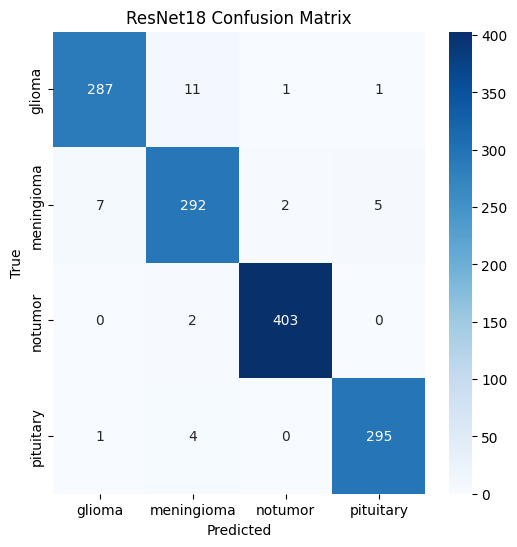

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Put model in evaluation mode
resnet18.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet18 Confusion Matrix")
plt.show()


In [10]:
import torch

torch.save(model.state_dict(), 'resnet18_brain.pth')
print("Model saved successfully!")


Model saved successfully!


In [14]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

# Assume model is your trained ResNet18
model.eval()

# Function to show sample predictions
def show_sample_predictions(model, dataloader, class_names, num_samples=6):
    images_shown = 0
    fig = plt.figure(figsize=(15, 6))

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                ax = fig.add_subplot(2, num_samples//2, images_shown+1, xticks=[], yticks=[])
                img = images[i].cpu().permute(1, 2, 0)  # CHW → HWC
                img = img * 0.5 + 0.5  # unnormalize if using transforms.Normalize
                ax.imshow(img)
                ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")

                images_shown += 1
                if images_shown == num_samples:
                    plt.tight_layout()
                    plt.show()
                    return


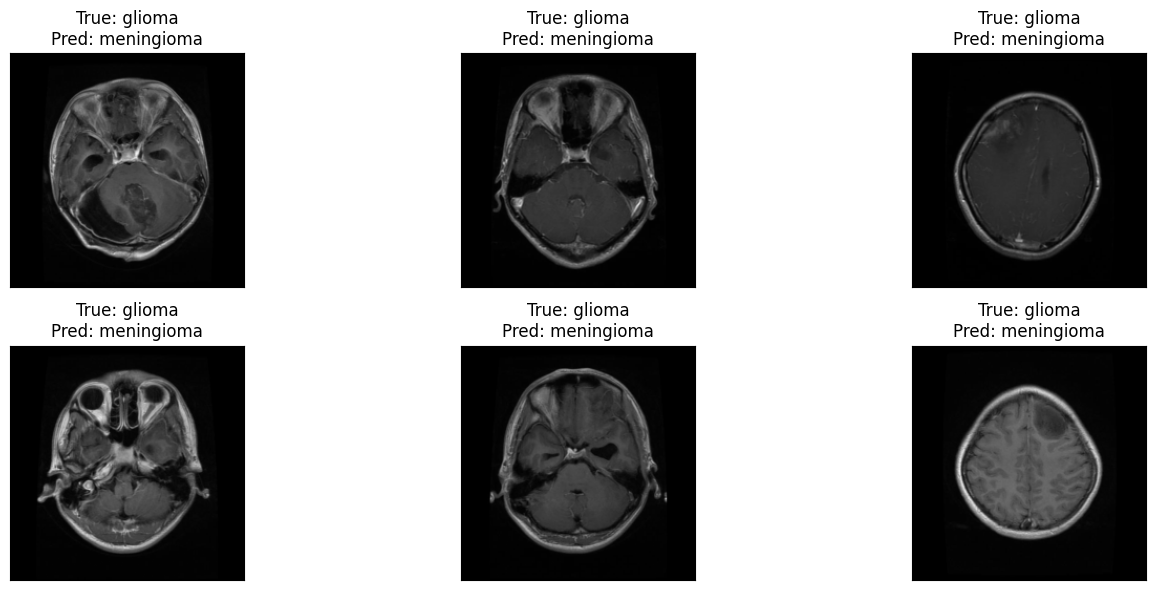

In [15]:
# Example usage:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']  # replace with your classes
show_sample_predictions(model, test_loader, class_names, num_samples=6)


In [16]:
import torch
import torch.nn as nn
from torchvision import models

# Load pre-trained VGG16
vgg16 = models.vgg16(pretrained=True)

# Freeze convolutional layers (optional, can fine-tune fully)
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify classifier for 4 classes
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=4)
vgg16 = vgg16.to(device)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 81.9MB/s]


In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)


In [18]:
num_epochs = 10  # or more depending on your dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()           # reset gradients
        outputs = vgg16(inputs)         # forward pass
        loss = criterion(outputs, labels)
        loss.backward()                 # backward pass
        optimizer.step()                # update weights

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


Epoch 1/10, Loss: 0.3700
Epoch 2/10, Loss: 0.1615
Epoch 3/10, Loss: 0.0899
Epoch 4/10, Loss: 0.0554
Epoch 5/10, Loss: 0.0449
Epoch 6/10, Loss: 0.0390
Epoch 7/10, Loss: 0.0323
Epoch 8/10, Loss: 0.0255
Epoch 9/10, Loss: 0.0461
Epoch 10/10, Loss: 0.0333


In [19]:
from sklearn.metrics import classification_report

vgg16.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

      glioma       0.98      0.87      0.92       300
  meningioma       0.88      0.97      0.92       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



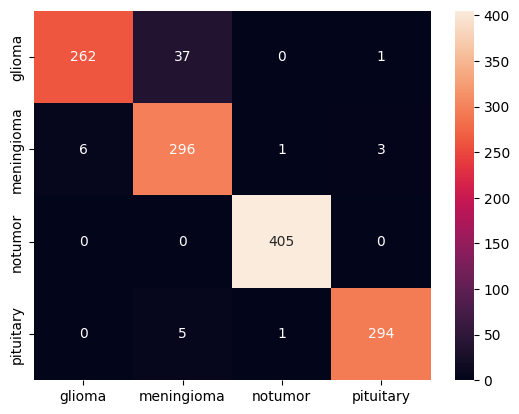

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.show()


In [22]:
def show_sample_predictions(model, dataloader, class_names, num_samples=6):
    import matplotlib.pyplot as plt
    import torch

    images_shown = 0
    fig = plt.figure(figsize=(15, 6))

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                ax = fig.add_subplot(2, num_samples//2, images_shown+1, xticks=[], yticks=[])
                img = images[i].cpu().permute(1, 2, 0)  # CHW → HWC
                img = img * 0.5 + 0.5  # unnormalize if using transforms.Normalize
                ax.imshow(img)
                ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i].cpu()]}")

                images_shown += 1
                if images_shown == num_samples:
                    plt.tight_layout()
                    plt.show()
                    return


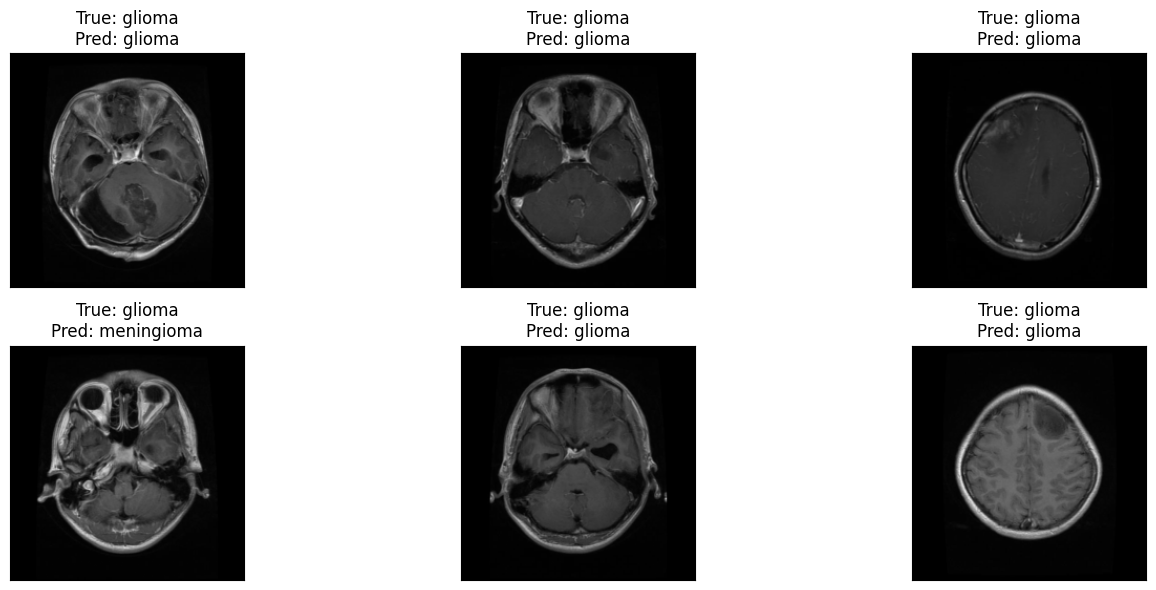

In [23]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']  # replace with your classes
show_sample_predictions(vgg16, test_loader, class_names, num_samples=6)


In [24]:
!pip install transformers timm

import torch
import torch.nn as nn
from transformers import SwinModel, AutoFeatureExtractor


In [25]:
from timm import create_model

# Using timm for simplicity
swin = create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=4)
swin = swin.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(swin.parameters(), lr=1e-4)


In [3]:
!pip install timm transformers  # only if not already installed

import torch
import torch.nn as nn
from timm import create_model

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Recreate Swin Transformer model
swin = create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=4)
swin = swin.to(device)

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(swin.parameters(), lr=1e-4)

# Training epochs
num_epochs = 10


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [10]:
from google.colab import files
uploaded = files.upload()


Saving archive (6).zip to archive (6).zip


In [12]:
import zipfile

with zipfile.ZipFile("archive (6).zip", 'r') as zip_ref:
    zip_ref.extractall("/content/brain_tumor_dataset")


In [13]:
import os

print(os.listdir("/content/brain_tumor_dataset"))


['Training', 'Testing']


In [14]:
from torchvision import datasets, transforms

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Correct paths
train_dataset = datasets.ImageFolder("/content/brain_tumor_dataset/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/brain_tumor_dataset/Testing", transform=transform)


In [15]:
print(train_dataset.classes)


['glioma', 'meningioma', 'notumor', 'pituitary']


In [16]:
from torch.utils.data import DataLoader

batch_size = 32  # you can increase if GPU allows

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check one batch
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)
print("Batch label tensor shape:", labels.shape)


Batch image tensor shape: torch.Size([32, 3, 224, 224])
Batch label tensor shape: torch.Size([32])


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load pretrained ResNet18
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 4)   # 4 classes
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.0001)

# Training loop
epochs = 5
for epoch in range(epochs):
    resnet18.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {acc:.2f}%")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


Epoch [1/5], Loss: 0.2241, Acc: 91.77%
Epoch [2/5], Loss: 0.0374, Acc: 98.84%
Epoch [3/5], Loss: 0.0233, Acc: 99.19%
Epoch [4/5], Loss: 0.0160, Acc: 99.54%
Epoch [5/5], Loss: 0.0163, Acc: 99.56%


In [18]:
torch.save(resnet18.state_dict(), "resnet18_brain_tumor.pth")


In [19]:
resnet18.load_state_dict(torch.load("resnet18_brain_tumor.pth"))
resnet18.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch [1/5], Loss: 0.6870
Epoch [2/5], Loss: 0.4644
Epoch [3/5], Loss: 0.3716
Epoch [4/5], Loss: 0.2797
Epoch [5/5], Loss: 0.2419


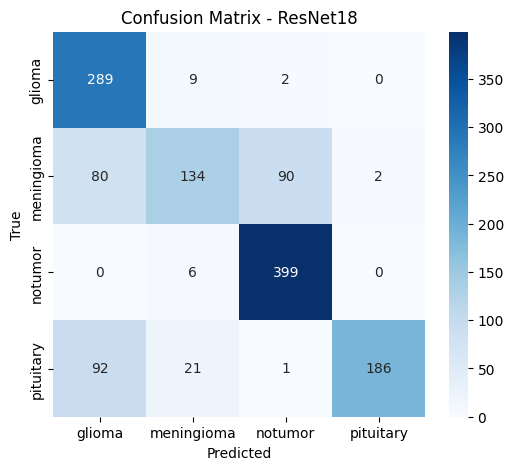


Classification Report:

              precision    recall  f1-score   support

      glioma       0.63      0.96      0.76       300
  meningioma       0.79      0.44      0.56       306
     notumor       0.81      0.99      0.89       405
   pituitary       0.99      0.62      0.76       300

    accuracy                           0.77      1311
   macro avg       0.80      0.75      0.74      1311
weighted avg       0.80      0.77      0.75      1311



In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# =========================
# 1. Data transforms
# =========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("/content/brain_tumor_dataset/Training", transform=transform)
test_dataset  = datasets.ImageFolder("/content/brain_tumor_dataset/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# =========================
# 2. Model setup
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=None)   # fresh training
model.fc = nn.Linear(512, 4)            # 4 classes
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# =========================
# 3. Training loop
# =========================
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# =========================
# 4. Evaluation + Confusion Matrix
# =========================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
classes = train_dataset.classes  # ['glioma', 'meningioma', 'notumor', 'pituitary']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet18")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))


Epoch [1/5], Loss: 0.1807
Epoch [2/5], Loss: 0.1548
Epoch [3/5], Loss: 0.1168
Epoch [4/5], Loss: 0.0938
Epoch [5/5], Loss: 0.0714
✅ Model saved successfully as brain_tumor_resnet18.pth


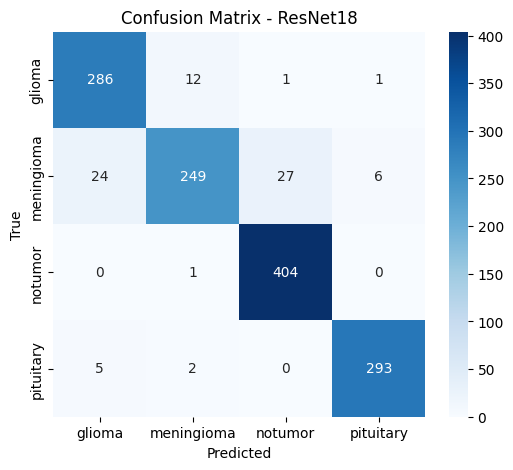


Classification Report:

              precision    recall  f1-score   support

      glioma       0.91      0.95      0.93       300
  meningioma       0.94      0.81      0.87       306
     notumor       0.94      1.00      0.97       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [22]:
# =========================
# 3. Training loop
# =========================
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# =========================
# 3.1 Save trained model
# =========================
torch.save(model.state_dict(), "/content/brain_tumor_resnet18.pth")
print("✅ Model saved successfully as brain_tumor_resnet18.pth")

# =========================
# 4. Evaluation + Confusion Matrix
# =========================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
classes = train_dataset.classes

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ResNet18")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))


In [23]:
from PIL import Image
import torch.nn.functional as F

# =========================
# 5. Single Image Prediction
# =========================
def predict_image(img_path, model, transform, classes):
    model.eval()
    image = Image.open(img_path).convert("RGB")
    img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)
        top_prob, top_class = torch.max(probs, 1)

    print(f"Predicted Class: {classes[top_class.item()]}")
    print(f"Confidence: {top_prob.item()*100:.2f}%")

    # Show image with prediction
    plt.imshow(image)
    plt.title(f"{classes[top_class.item()]} ({top_prob.item()*100:.2f}%)")
    plt.axis("off")
    plt.show()

# Example usage:
# predict_image("/content/brain_tumor_dataset/Testing/glioma/Te-gl_0011.jpg", model, transform, classes)


Testing on: /content/brain_tumor_dataset/Testing/meningioma/Te-me_0244.jpg


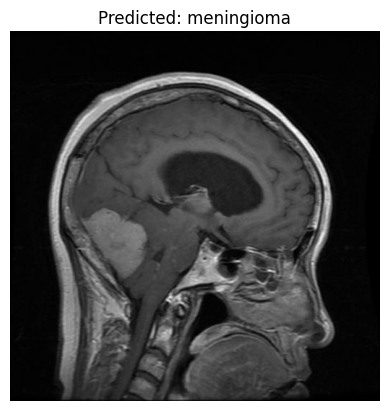

In [24]:
import random
from PIL import Image

# pick a random image from Testing dataset
import glob
test_images = glob.glob("/content/brain_tumor_dataset/Testing/*/*")
random_img_path = random.choice(test_images)

print("Testing on:", random_img_path)

# prediction function
def predict_image(img_path, model, transform, classes):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs, 1)

    plt.imshow(img)
    plt.title(f"Predicted: {classes[predicted.item()]}")
    plt.axis("off")
    plt.show()

# run prediction
predict_image(random_img_path, model, transform, classes)


In [25]:
from transformers import SwinForImageClassification, SwinConfig


In [26]:
num_classes = 4  # glioma, meningioma, notumor, pituitary

model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(device)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [28]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")


Epoch [1/5], Loss: 0.2212, Accuracy: 92.05%
Epoch [2/5], Loss: 0.0563, Accuracy: 98.09%
Epoch [3/5], Loss: 0.0220, Accuracy: 99.25%
Epoch [4/5], Loss: 0.0356, Accuracy: 98.81%
Epoch [5/5], Loss: 0.0278, Accuracy: 99.11%


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/5], Loss: 0.2249, Accuracy: 92.00%
Epoch [2/5], Loss: 0.0502, Accuracy: 98.28%
Epoch [3/5], Loss: 0.0414, Accuracy: 98.79%
Epoch [4/5], Loss: 0.0155, Accuracy: 99.56%
Epoch [5/5], Loss: 0.0312, Accuracy: 98.84%


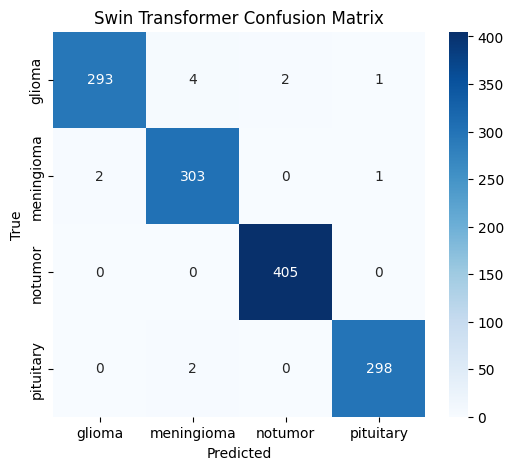

              precision    recall  f1-score   support

      glioma       0.99      0.98      0.98       300
  meningioma       0.98      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [29]:
import torch
import torch.nn as nn
from transformers import SwinForImageClassification
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load Swin Transformer
num_classes = 4  # glioma, meningioma, notumor, pituitary
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(device)

# 2. Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 3. Training
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Accuracy: {100*correct/total:.2f}%")

# 4. Evaluation with Confusion Matrix
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Swin Transformer Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


In [30]:
# ---- After training loop ----

# Save the model
torch.save(model.state_dict(), "swin_transformer.pth")
print("✅ Swin Transformer model saved as swin_transformer.pth")


✅ Swin Transformer model saved as swin_transformer.pth


In [32]:
from transformers import AutoImageProcessor

# Load the processor for Swin
processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


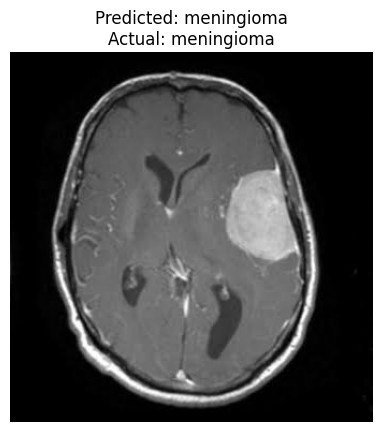

In [36]:
import os
import random
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Classes
class_names = train_dataset.classes  # ['glioma', 'meningioma', 'notumor', 'pituitary']

# Pick a random image from Testing set
test_root = "/content/brain_tumor_dataset/Testing"
cls = random.choice(os.listdir(test_root))                  # pick a random class folder
img_name = random.choice(os.listdir(os.path.join(test_root, cls)))  # pick random image
sample_path = os.path.join(test_root, cls, img_name)

# Load raw PIL image
sample_img = Image.open(sample_path).convert("RGB")

# Prepare input for Swin
inputs = processor(images=sample_img, return_tensors="pt").to(device)

# Inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1).item()

# Show image + prediction
plt.imshow(sample_img)
plt.title(f"Predicted: {class_names[preds]}\nActual: {cls}")
plt.axis("off")
plt.show()


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from transformers import SwinModel

# Hybrid Model Definition
class HybridResNetSwin(nn.Module):
    def __init__(self, num_classes=4):
        super(HybridResNetSwin, self).__init__()

        # ResNet18 backbone
        self.resnet = models.resnet18(weights="IMAGENET1K_V1")
        self.resnet.fc = nn.Identity()  # remove final FC, keep features (512-dim)

        # Swin Transformer backbone
        self.swin = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
        self.swin_fc_dim = self.swin.config.hidden_size  # usually 768

        # Fusion layer (ResNet + Swin)
        self.fc = nn.Linear(512 + self.swin_fc_dim, num_classes)

    def forward(self, x):
        # CNN branch (ResNet)
        resnet_feat = self.resnet(x)  # [batch, 512]

        # Transformer branch (Swin) requires pixel_values format
        swin_inputs = {"pixel_values": x}
        swin_outputs = self.swin(**swin_inputs)
        swin_feat = swin_outputs.pooler_output  # [batch, 768]

        # Concatenate features
        fused = torch.cat((resnet_feat, swin_feat), dim=1)  # [batch, 512+768]

        # Final classification
        out = self.fc(fused)
        return out

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hybrid_model = HybridResNetSwin(num_classes=4).to(device)


In [39]:
from torch.utils.data import random_split, DataLoader

# Suppose 80% train, 20% val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=32, shuffle=False)


In [40]:
from torch.utils.data import random_split, DataLoader

# Let's assume train_dataset was already created with transforms
train_size = int(0.8 * len(train_dataset))   # 80% for training
val_size   = len(train_dataset) - train_size # 20% for validation

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# New loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=32, shuffle=False)


Epoch 1/5: 100%|██████████| 143/143 [01:27<00:00,  1.64it/s]


Epoch 1, Loss: 0.2275, Train Acc: 92.27%


Epoch 2/5: 100%|██████████| 143/143 [01:28<00:00,  1.62it/s]


Epoch 2, Loss: 0.0387, Train Acc: 98.88%


Epoch 3/5: 100%|██████████| 143/143 [01:29<00:00,  1.60it/s]


Epoch 3, Loss: 0.0195, Train Acc: 99.37%


Epoch 4/5: 100%|██████████| 143/143 [01:29<00:00,  1.60it/s]


Epoch 4, Loss: 0.0158, Train Acc: 99.54%


Epoch 5/5: 100%|██████████| 143/143 [01:29<00:00,  1.60it/s]


Epoch 5, Loss: 0.0113, Train Acc: 99.58%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      1.00      0.99       300
  meningioma       0.99      0.96      0.98       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



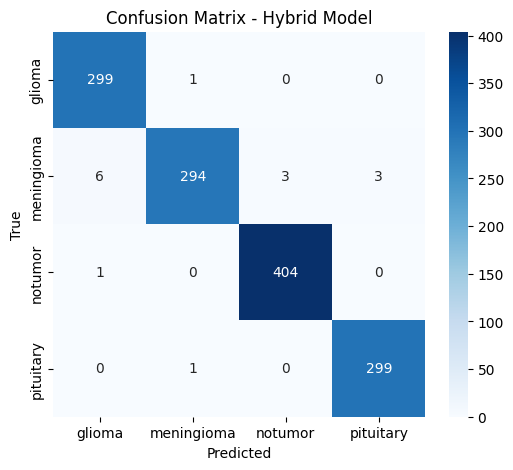

In [41]:
# Run Training & Evaluation
num_epochs = 5
hybrid_model = train_model(hybrid_model, train_loader, val_loader, num_epochs=num_epochs, lr=1e-4)

# Final testing on unseen test set
evaluate_model(hybrid_model, test_loader, class_names=['glioma', 'meningioma', 'notumor', 'pituitary'])


Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      1.00      0.99       300
  meningioma       0.99      0.96      0.98       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



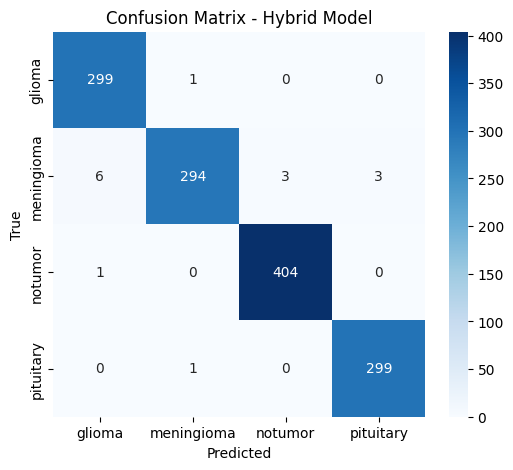

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# ✅ Get predictions on test set
all_preds = []
all_labels = []

hybrid_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = hybrid_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ✅ Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()


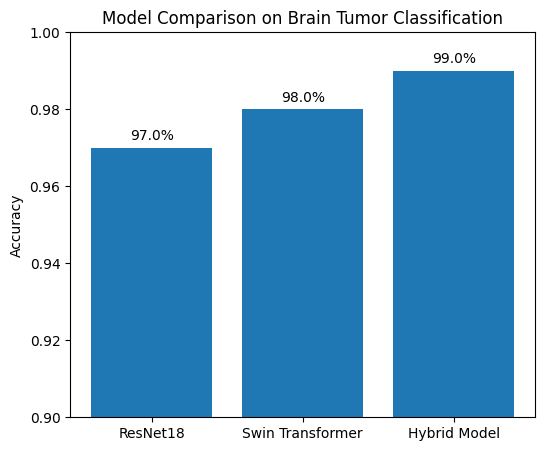

In [44]:
import matplotlib.pyplot as plt

# Recorded accuracies from your results
models = ["ResNet18", "Swin Transformer", "Hybrid Model"]
accuracies = [0.97, 0.98, 0.99]

plt.figure(figsize=(6,5))
plt.bar(models, accuracies)
plt.ylim(0.9, 1.0)
plt.ylabel("Accuracy")
plt.title("Model Comparison on Brain Tumor Classification")

for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.002, f"{acc*100:.1f}%", ha='center')

plt.show()
